# Getting Started

## construct `tensors`
Tensors are similar to NumPy’s ndarrays, with the addition being that Tensors can also be used on a GPU to accelerate computing.

In [25]:
import torch
x = torch.empty(3, 2)
print(x)

tensor([[ 0.0000e+00, -2.0000e+00],
        [-5.9384e-33,  3.6902e+19],
        [ 2.8026e-45,  0.0000e+00]])


In [2]:
torch.manual_seed(1234)
x = torch.rand(3, 2) # a uniform distribution on the interval [0, 1)
print(x)

tensor([[0.0290, 0.4019],
        [0.2598, 0.3666],
        [0.0583, 0.7006]])


In [3]:
x = torch.zeros(3, 2, dtype=torch.long)
print(x)

tensor([[0, 0],
        [0, 0],
        [0, 0]])


Construct a tensor directly from data:

In [4]:
x = torch.tensor([5.5, 3])
print(x)

tensor([5.5000, 3.0000])


or create a tensor based on an existing tensor. These methods will reuse properties of the input tensor, e.g. dtype, unless new values are provided by user

In [5]:
y = x.new_ones(3, 2, dtype=torch.double)      # new_* methods take in sizes
z = torch.randn_like(y, dtype=torch.float)    # override dtype!
print(y)
print(z) 

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], dtype=torch.float64)
tensor([[-0.8545,  0.5098],
        [-0.0821,  0.6607],
        [ 0.0785,  0.7884]])


In [6]:
# torch.Size is in fact a tuple, so it supports all tuple operations.
print(y.size(), z.size()) 

torch.Size([3, 2]) torch.Size([3, 2])


## Operations
[Full Reference](https://pytorch.org/docs/stable/torch.html)

In [20]:
x = torch.ones(4, 2, dtype=torch.long)
y = torch.ones(4, 2, dtype=torch.long) * 2
z = torch.add(x, y)
print(z)

tensor([[3, 3],
        [3, 3],
        [3, 3],
        [3, 3]])


Any operation that mutates a tensor in-place is post-fixed with an `_`. For example: `x.t_()`, will change `x`.

In [21]:
x = torch.ones(4, 2, dtype=torch.long)
x.size()

torch.Size([4, 2])

In [22]:
x.t_()
x.size()

torch.Size([2, 4])

You can use standard NumPy-like indexing with all bells and whistles!

In [25]:
z[:, [1]].size()

torch.Size([4, 1])

You can use `view` to reshape tensors.

In [27]:
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
print(x.size(), y.size(), z.size())

torch.Size([4, 4]) torch.Size([16]) torch.Size([2, 8])


## Communicate with `Numpy`

### `tensor` `->` `array`

In [41]:
x_torch = torch.ones(5)
x_np = x_torch.numpy()

In [42]:
x_torch, x_np

(tensor([1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1.], dtype=float32))

In [43]:
# this will also change the value of x_np
x_torch.add_(2), x_np

(tensor([3., 3., 3., 3., 3.]), array([3., 3., 3., 3., 3.], dtype=float32))

### `array` `->` `tensor` 

In [45]:
import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
a,b

(array([2., 2., 2., 2., 2.]),
 tensor([2., 2., 2., 2., 2.], dtype=torch.float64))

## Load Datasets

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [6]:
landmarks_frame = pd.read_csv('./data/faces/face_landmarks.csv')

n = 2
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))


Image name: 10comm-decarlo.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 66. 114.]
 [ 65. 128.]
 [ 67. 142.]
 [ 68. 156.]]


In [5]:
landmarks_frame.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


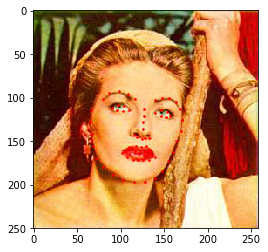

In [9]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('./data/faces/', img_name)),
               landmarks)
plt.show()

In [ ]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""
   
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        super(FaceLandmarksDataset, self).__init__()
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = None

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (324, 215, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (250, 258, 3) (68, 2)
3 (434, 290, 3) (68, 2)


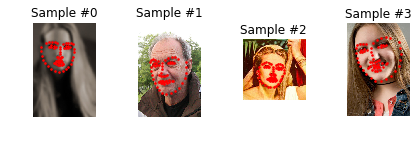

In [31]:
face_dataset = FaceLandmarksDataset(csv_file='./data/faces/face_landmarks.csv',
                                    root_dir='./data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

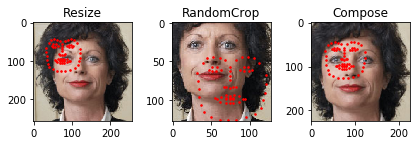

In [67]:
from PIL import Image
scale = transforms.Resize(256)
crop = transforms.RandomCrop(128)
composed = transforms.Compose([scale, transforms.RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
img =  Image.fromarray(sample["image"])

for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(img)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(transformed_sample, sample["landmarks"])

plt.show() 

# nn.Module
## nn.Conv2d
**function** `nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)`
 


* Args:
    * in_channels (int): Number of channels in the input image
    * out_channels (int): Number of channels produced by the convolution
    * kernel_size (int or tuple): Size of the convolving kernel
    * stride (int or tuple, optional): Stride of the convolution. Default: 1
    * padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
    * bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``

* The parameters `kernel_size`, `stride`, `padding`, `dilation` can either be:

    - a single ``int`` -- in which case the same value is used for the height and width dimension
    - a ``tuple`` of two ints -- in which case, the first `int` is used for the height dimension,
      and the second `int` for the width dimension

* Shape:
    - Input: $(N, C_{in}, H_{in}, W_{in})$
    - Output: $(N, C_{out}, H_{out}, W_{out})$ where


$$H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
        \times (\text{kernel_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$$

$$W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
        \times (\text{kernel_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor$$

* Attributes:
    * weight (Tensor): the learnable weights of the module of shape (out_channels, in_channels, kernel_size[0], kernel_size[1])
    * bias (Tensor):   the learnable bias of the module of shape (out_channels)

In the simplest case, the output value of the layer with input size
$(N, C_{in}, H, W)$ and output $(N, C_{out}, H_{out}, W_{out})$
can be precisely described as:


$$
\begin{equation*}
\text{out}(N_i, C_{out_j}) = \text{bias}(C_{out_j}) +
                        \sum_{k = 0}^{C_{in} - 1} \text{weight}(C_{out_j}, k) \star \text{input}(N_i, k)
\end{equation*},
$$
where $\star$ is the valid 2D `cross-correlation` operator, $N$ is a batch size, $C$ denotes a number of channels, $H$ is a height of input planes in pixels, and $W$ is width in pixels.
Note that $\sum_{k = 0}^{C_{in} - 1} \text{weight}(C_{out_j}, k) \star \text{input}(N_i, k)$ is actually doing 2d-convolution on each input channel with its corresponding kernel and superimposing them by doing the summation.

## max_pool2d
**function** F.max_pool2d(input, kernel_size, stride=None, padding=0, dilation=1, ceil_mode=False, return_indices=False):
   
In the simplest case, the output value of the layer with input size $(N, C, H, W)$,
output $(N, C, H_{out}, W_{out})$ and `kernel_size` $(kH, kW)$ can be precisely described as:


$$
\begin{equation*}
\text{out}(N_i, C_j, h, w)  = \max_{m=0, \ldots, kH-1} \max_{n=0, \ldots, kW-1}
                       \text{input}(N_i, C_j, \text{stride}[0] * h + m, \text{stride}[1] * w + n)
\end{equation*}
$$



* Args:
    * kernel_size: the size of the window to take a max over
    * stride: the stride of the window. Default value is :attr:`kernel_size`
    * padding: implicit zero padding to be added on both sides
    * dilation: a parameter that controls the stride of elements in the window
    * return_indices: if ``True``, will return the max indices along with the outputs. Useful when Unpooling later
    * ceil_mode: when True, will use `ceil` instead of `floor` to compute the output shape

* Shape:
    - Input: :math:`(N, C, H_{in}, W_{in})`
    - Output: :math:`(N, C, H_{out}, W_{out})`

The parameters :attr:`kernel_size`, :attr:`stride`, :attr:`padding`, :attr:`dilation` can either be:
- a single ``int`` -- in which case the same value is used for the height and width dimension
- a ``tuple`` of two ints -- in which case, the first `int` is used for the height dimension,
  and the second `int` for the width dimension

## nn.Linear
**function** nn.Linear(in_features, out_features, bias=True)

* Args:
    * in_features: size of each input sample
    * out_features: size of each output sample
    * bias: If set to False, the layer will not learn an additive bias. Default: ``True``

* Shape:
    - Input: $(N, *, in\_features)$ where $*$ means any number of
      additional dimensions
    - Output: $(N, *, out\_features)$ where all but the last dimension
      are the same shape as the input.

* Attributes:
    * weight: the learnable weights of the module of shape`(out_features x in_features)`
    * bias:   the learnable bias of the module of shape `(out_features)`


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [2]:
net = Net()
params = list(net.parameters())

In [3]:
# for convolution layer
params[0].shape, params[1].shape, params[2].shape, params[3].shape

(torch.Size([6, 1, 5, 5]),
 torch.Size([6]),
 torch.Size([16, 6, 5, 5]),
 torch.Size([16]))

In [4]:
# for fully-connected layer
params[4].shape, params[5].shape, params[6].shape, params[7].shape

(torch.Size([120, 400]),
 torch.Size([120]),
 torch.Size([10, 120]),
 torch.Size([10]))

In [5]:
torch.manual_seed(1234)
x = torch.rand(1, 1, 32, 32)
out = net(x)
print(out)

tensor([[-0.0301,  0.0331, -0.0120, -0.1129,  0.0474,  0.0395,  0.0222, -0.0106,
          0.0394,  0.1513]], grad_fn=<ThAddmmBackward>)


In [6]:
x1_ = net.conv1(x)
x1 = F.max_pool2d(F.relu(net.conv1(x)), (2, 2))
x.shape, x1_.shape, x1.shape

(torch.Size([1, 1, 32, 32]),
 torch.Size([1, 6, 28, 28]),
 torch.Size([1, 6, 14, 14]))

In [7]:
x2 = F.max_pool2d(F.relu(net.conv2(x1)), 2)
x2.shape

torch.Size([1, 16, 5, 5])

In [8]:
def num_flat_features(x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

In [9]:
temp = x2.view(-1, num_flat_features(x2))
temp.shape

torch.Size([1, 400])

In [ ]:
x3 = F.relu(net.fc1(temp))
x3.shape

In [ ]:
net.fc3(x3)

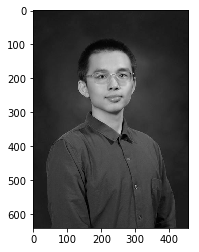

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('./data/me.jpg')
imgplot = plt.imshow(img)
plt.show()

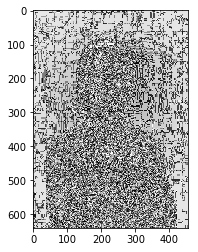

In [24]:
from scipy import signal
b = np.array([[0.1,0.2], [0.3,0.4]])
conv = np.zeros((640, 456,3))
conv[:,:,0] = signal.correlate2d(img[:,:,0], b, mode='valid', boundary='wrap')
conv[:,:,1] = signal.correlate2d(img[:,:,1], b, mode='valid', boundary='wrap')
conv[:,:,2] = signal.correlate2d(img[:,:,2], b, mode='valid', boundary='wrap')
imgplot = plt.imshow(conv)
plt.show()

In [21]:
conv.shape

(640, 456, 3)

## `Optim` Module